## Test in non-parametric SFHs 

The purpose of this notebook is to test how a model trained only with linear-exp SFHs performs with flexible non-parametric SFHs generated with dense_basis package (GP-SFH module).

In [6]:
import numpy as np
import dense_basis as db
import matplotlib.pyplot as plt
from generate_non_parametric_sample import *

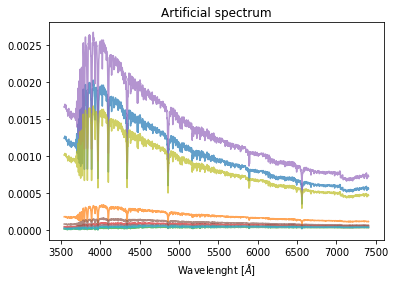

0.9999999999999999


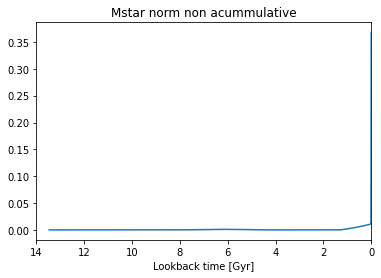

1.0


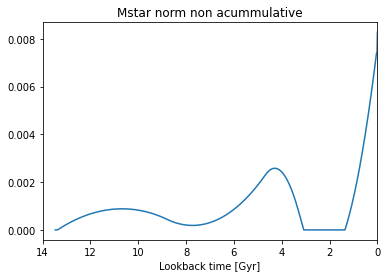

1.0


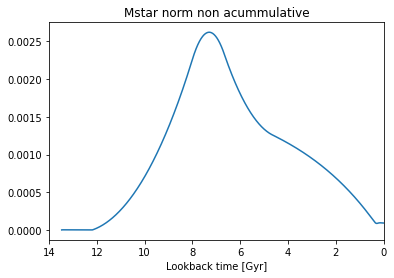

1.0


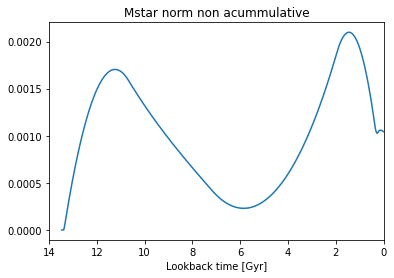

1.0000000000000002


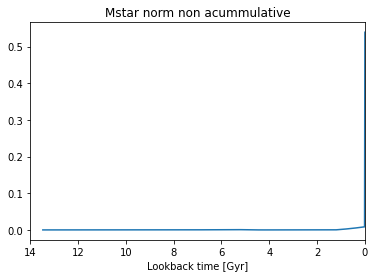

1.0


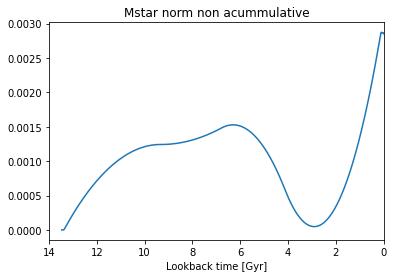

1.0


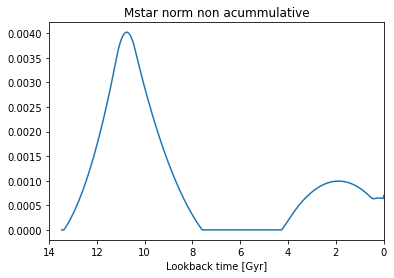

1.0


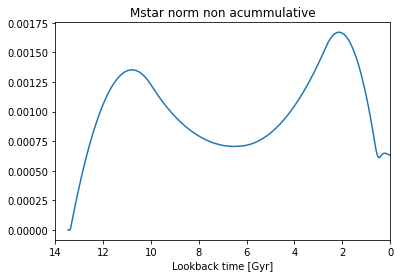

1.0000000000000002


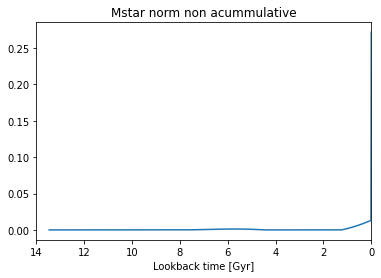

0.9999999999999999


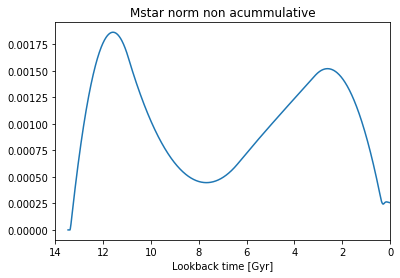

In [7]:
t,ms,percentiles=generate_weights_from_SFHs_non_param(100)
wave,data=get_data(dir_name='../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
data_extended=interpolate(tbins,t[0],data)
wave,seds=generate_all_spectrums(t[0],ms,wave,data_extended)

plot_sed_sfh(ms,t[0],wave,seds,10) 

In [8]:
import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader

from spender import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange

from sbi import utils as Ut
from sbi import inference as Inference

import pickle

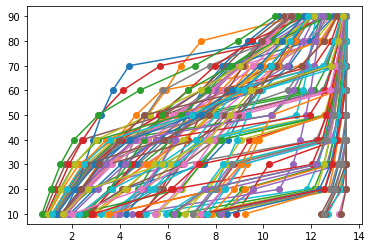

In [9]:
#just a quick check of the percentiles

for i in range(len(percentiles[:,0])):
    plt.plot(percentiles[i,:],np.arange(10,100,10),'-o')

Now that we have our input (spectra + real percentiles) we load a trained model and use it to predict the percentiles of these spectra

In [11]:
wave=np.array(wave)
seds=np.array(seds)

In [13]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x,y):

        """ generate and organize artificial data from parametrizations of SFHs"""

        self.x=torch.from_numpy(x) #seds
        self.y=torch.from_numpy(y) #percentiles


    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        y=self.y[index,:]
        return x,y

#create a pytorch dataset

dataset = Dataset(seds[:,:], percentiles[:,:])
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file ="./old_trained_models/checkpoint.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=9)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch[0].float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

Getting latent vectors and predicted percentiles


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 25.97it/s]


In [14]:
file="./old_trained_models/my_posterior_1e5_m216.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

In [15]:
posteriors=[]


for i in trange(100):
    posteriors.append(np.array(qphi.sample((1,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)[:,0,:]

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 36.01it/s]


(100, 9)


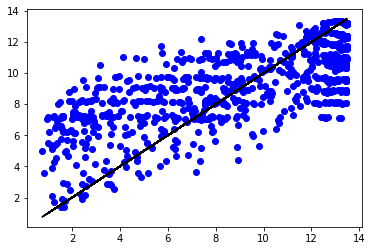

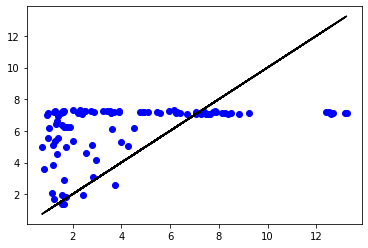

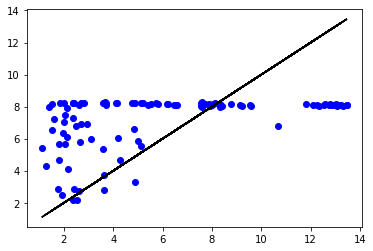

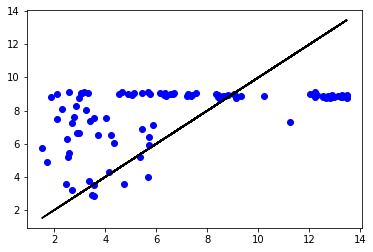

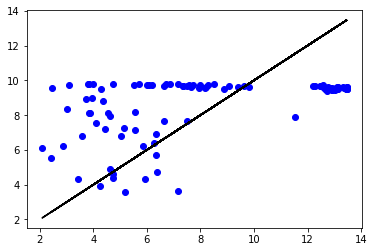

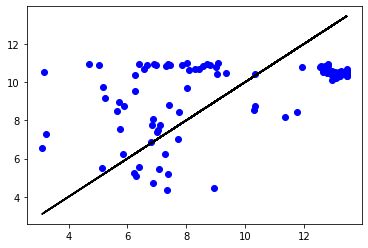

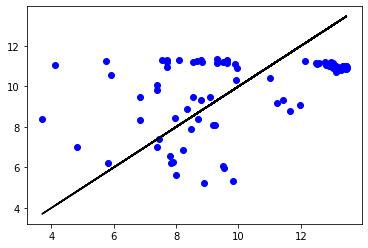

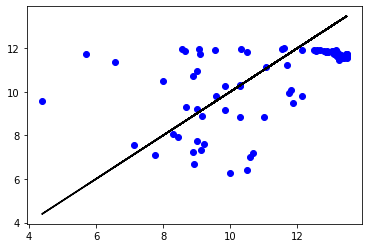

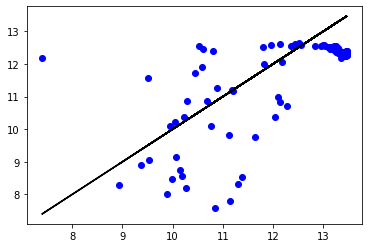

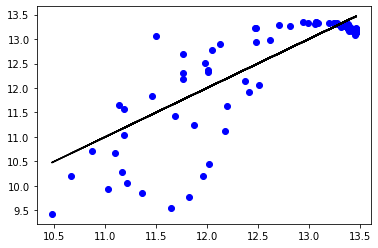

In [16]:
print(np.shape(posteriors))

for i in range(9):
    plt.plot(percentiles[:,i],posteriors[:,i],'bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
plt.show()

for i in range(9):
    plt.plot(percentiles[:,i],posteriors[:,i],'bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
    plt.show()

In [17]:
posteriors_dist=[]


for i in trange(100):
    posteriors_dist.append(np.array(qphi.sample((1000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors_dist=np.array(posteriors_dist)

100%|█████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


(100, 1000, 9)
(100, 9)


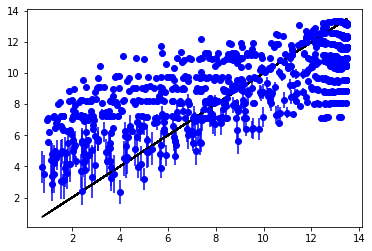

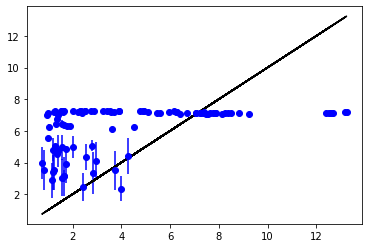

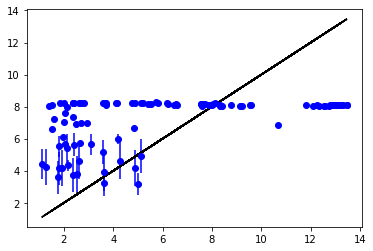

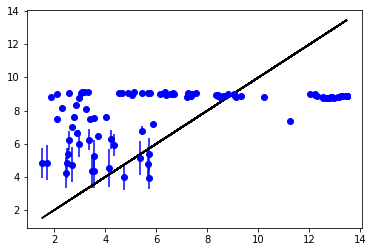

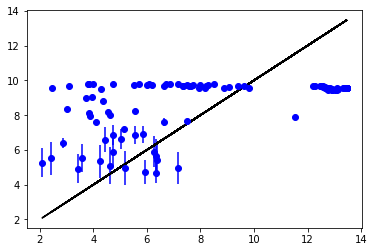

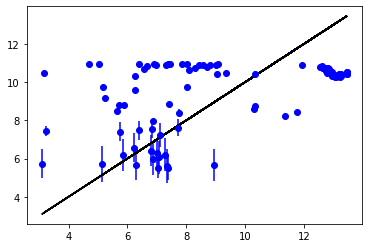

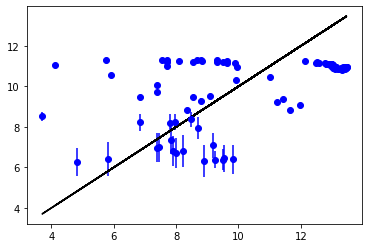

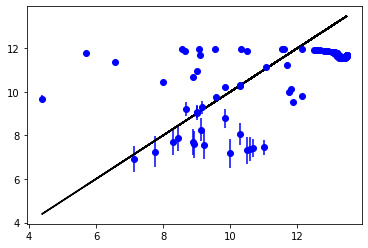

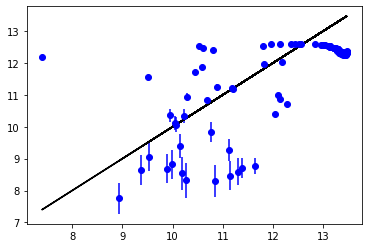

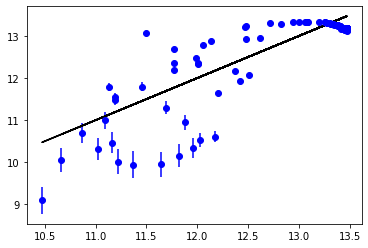

In [18]:
print(np.shape(posteriors_dist))

means=np.mean(posteriors_dist,axis=1)
stds=np.std(posteriors_dist,axis=1)

print(np.shape(means))


for i in range(9):
    plt.errorbar(percentiles[:,i],means[:,i],yerr=stds[:,i],fmt='bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
plt.show()


for i in range(9):
    plt.errorbar(percentiles[:,i],means[:,i],yerr=stds[:,i],fmt='bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
    plt.show()

In [19]:
import math

def get_coverage_probabilities_nomodel(y_real,y_pred,y_pred_std):
    """
    Compute the coverage probabilities on test dataset
    
    :param y:  The data true values
    :param y_pred: The mean of the predicted distributions
    :param y_pred_std: The standard deviation of the predicted distributions
    :return: (x, y) a tuple of lists corresponding to a list of probability volumes
    and the corresponding percentage of true values in that volume.
    """
    

    errors = np.absolute(y_real - y_pred)
    x, y = [], []
    for sigma_times in np.arange(0, 3, 0.01):
        how_many = np.count_nonzero(errors <= sigma_times * y_pred_std)
        y.append(how_many / y_real.shape[0])
        x.append(math.erf(sigma_times / math.sqrt(2))) #the method erf returns the error function of a number.
    return x, y


def plot_with_median(data_x, data_y,ax, label=None, percentiles=(16, 84), total_bins=20):
    """
    Plot the running media of the data_x, data_y data with requested percentiles.
    :param data_x:
    :param data_y:
    :param label: The label that should be displayed on the legend
    :param percentiles: The percentiles to plot along with the median
    :param total_bins: The number of bins to digitize the data. Increase to increase detail.
    :return:
    """
    bins = np.linspace(data_x.min(), data_x.max(), total_bins)

    delta = bins[1] - bins[0]
    idx = np.digitize(data_x, bins)
    running_median = [np.nanmedian(data_y[idx == k]) for k in range(total_bins)]
    running_prc_low = [np.nanpercentile(data_y[idx == k], percentiles[0])
                       for k in range(total_bins)]
    running_prc_high = [np.nanpercentile(data_y[idx == k], percentiles[1])
                        for k in range(total_bins)]

    if percentiles:
        ax.plot(bins-delta/2, running_median, lw=2, alpha=.8, color='blue', label=label)
        ax.fill_between(bins - delta / 2, running_prc_low, running_median, color='blue', alpha=0.1)
        ax.fill_between(bins - delta / 2, running_prc_high, running_median, color='blue', alpha=0.1)
    else:
        ax.plot(bins - delta / 2, running_median, linestyle='--', lw=2, alpha=.8,  label=label)
        
        
def init_coverage_plot():
    """
    Initialize the coverage plot and add text for marking
    overconfident and conservative regions
    :return:
    """
    f = plt.figure(figsize=(10, 8))
    ax = f.add_subplot()
    ax.set_xlabel('Percentage of probability volume')
    ax.set_ylabel('Percentage of true values in volume')
    ax.set_title('Probability Coverage')

    plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    plt.text(0.3, 0.9, '$\it{Conservative}$',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)

    plt.text(0.7, 0.1, '$\it{Overconfident}$',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)
    return f, ax

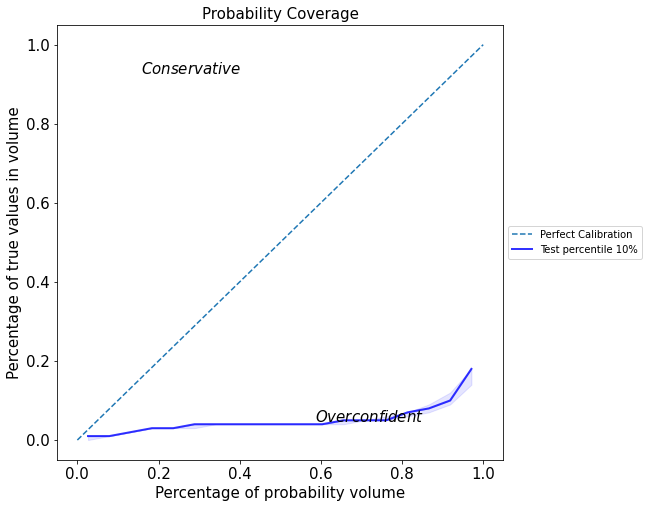

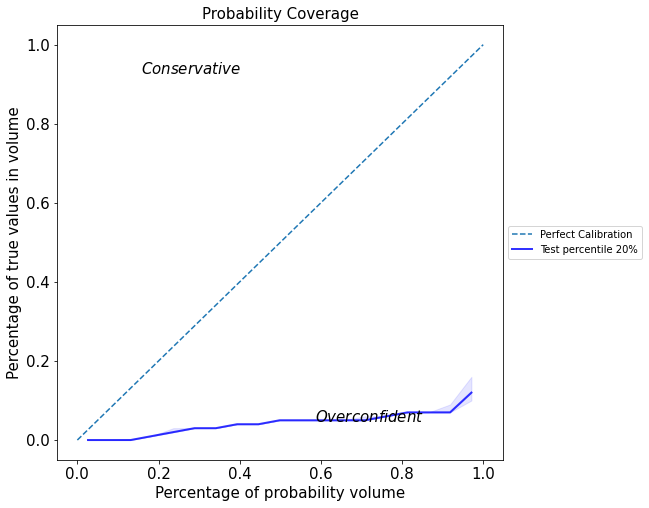

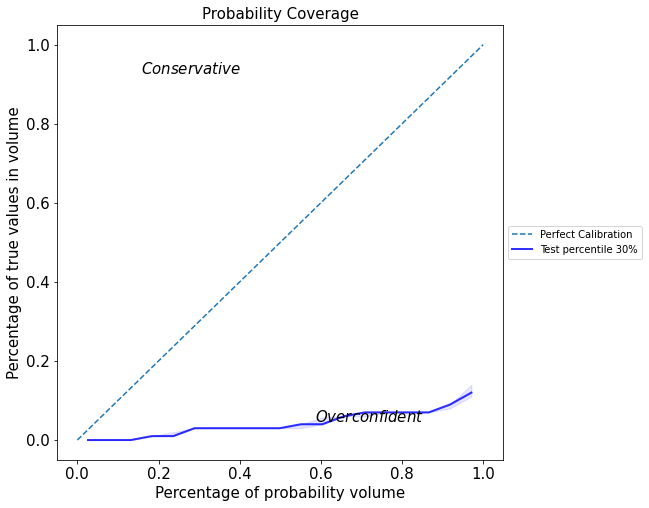

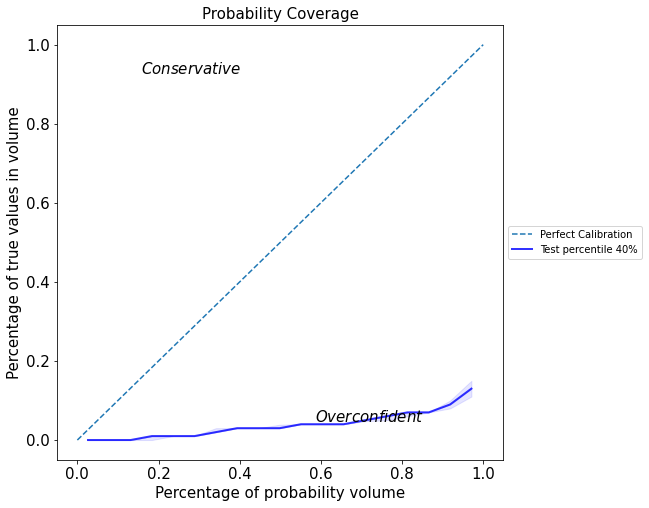

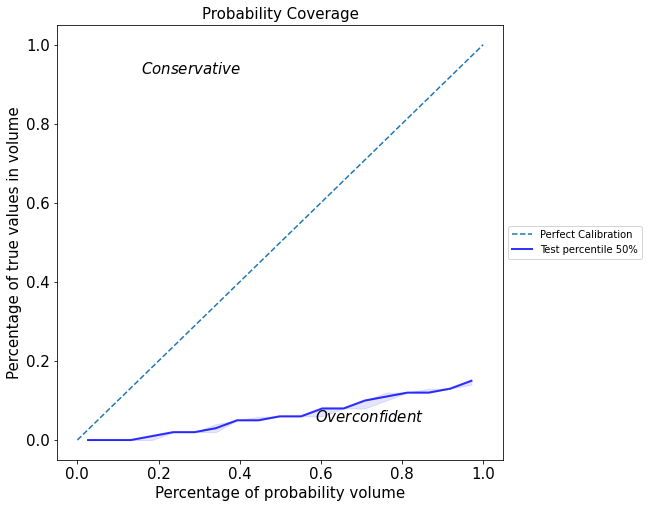

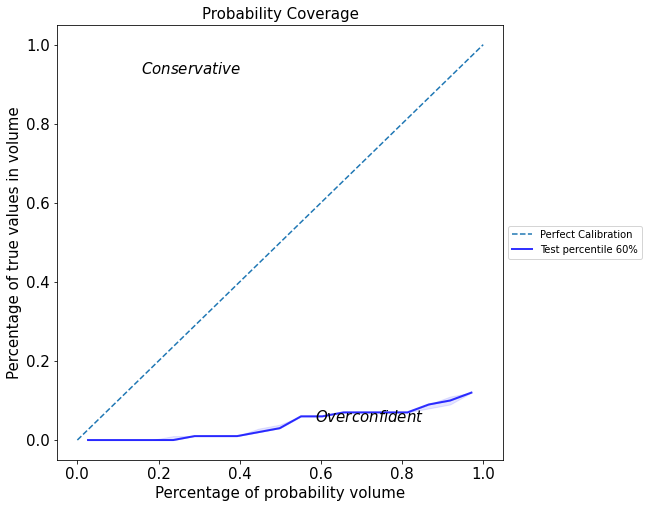

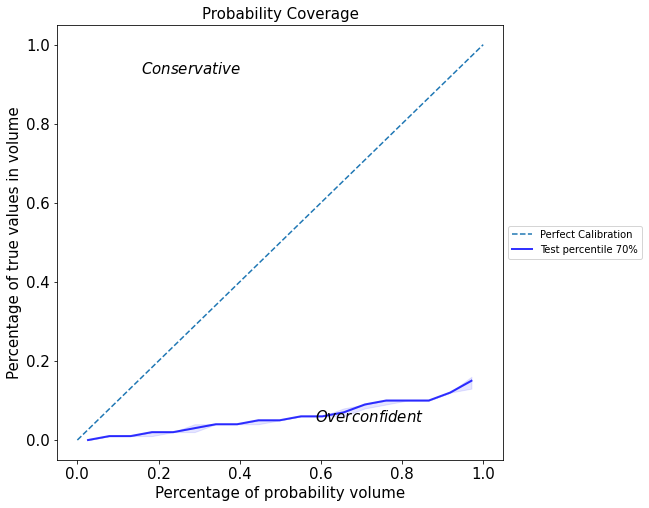

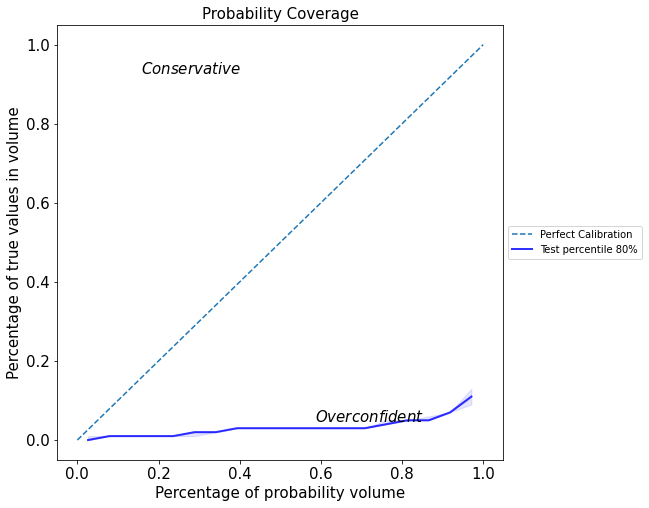

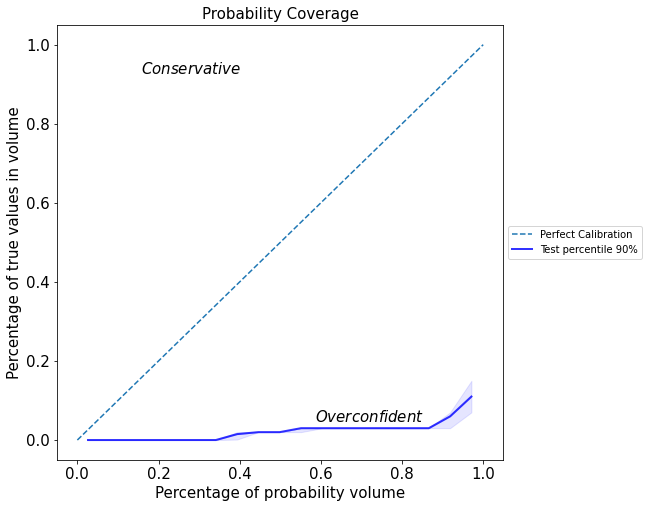

In [20]:
y=np.copy(percentiles)
y_pred=np.copy(means)
y_pred_std=np.copy(stds)


for i in range(9):
    
    data_x,data_y=get_coverage_probabilities_nomodel(np.array(y)[:,i],y_pred[:,i],y_pred_std[:,i])
    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', titlesize=15, labelsize=15)
    f, ax =init_coverage_plot()
    
    if i<9:
        plot_with_median(np.array(data_x), np.array(data_y), ax, label='Test percentile '+str((i+1)*10)+'%')
    else:
        plot_with_median(np.array(data_x), np.array(data_y), ax, label='Metallicity')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

    #plt.savefig('coverage_'+str(i)+'.jpg')
    plt.show()
    plt.close()

